In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mltools import my_convert_to_number, my_convert_to_date
from wordcloud import WordCloud
from collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
sns.set(style="darkgrid")

In [2]:
odi_df = pd.read_csv('ODI-2022.csv',delimiter=";")

### Number of records

In [3]:
print(len(odi_df.index))

304


### Number of attributes

In [4]:
print(len(odi_df.columns))

17


### Attributes are
    

In [5]:
print((odi_df.columns))

Index(['Tijdstempel', 'What programme are you in?',
       'Have you taken a course on machine learning?',
       'Have you taken a course on information retrieval?',
       'Have you taken a course on statistics?',
       'Have you taken a course on databases?', 'What is your gender?',
       'Chocolate makes you.....', 'When is your birthday (date)?',
       'Number of neighbors sitting around you?', 'Did you stand up?',
       'What is your stress level (0-100)?',
       'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ',
       'Give a random number', 'Time you went to be Yesterday',
       'What makes a good day for you (1)?',
       'What makes a good day for you (2)?'],
      dtype='object')


### Replace columns name

In [6]:
 odi_df.columns = ['time',\
                   'program',\
                   'ML',\
                   'IR',\
                   'Statistics',\
                   'DB',\
                   'Gender',\
               'Chocolate_influence',\
                   'Birthday',\
                   'neighbors',\
                   'Stand_Up',\
                   'Stress',\
              'Euros_Question',\
                   'random_number',\
                   'time_to_bed',\
                   'good_day_1',\
                   'good_day_2']
display(odi_df)

,time,program,ML,IR,Statistics,DB,Gender,Chocolate_influence,Birthday,neighbors,Stand_Up,Stress,Euros_Question,random_number,time_to_bed,good_day_1,good_day_2
0,4-5-2022 12:12:07,artificial intelligence,yes,0,mu,nee,female,neither,02.05.1998,0,no,0,5,888,23:00,coffee,sun
1,4-5-2022 12:12:07,big data,yes,0,mu,nee,male,fat,29-02-2000,0,yes,200,1,12,32,7777,8964
2,4-5-2022 12:12:09,Computational Science,yes,1,mu,ja,male,fat,29-06-1998,1,no,0,100,9,x,0,0
3,4-5-2022 12:12:09,Bioinformatics and Systems Biology,yes,0,unknown,nee,male,neither,11/05/97,0,no,20,100,31,14:00,good food,no stress
4,4-5-2022 12:12:15,AI,yes,1,mu,ja,male,fat,03-10-1997,0,no,2,100,86,07:20,Sunshine,Good Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,4-5-2022 12:35:31,Ai,yes,1,unknown,nee,not willing to answer,fat,1/1/1956,2,no,30,99,6,5,Yes,No
300,4-5-2022 12:37:05,E,yes,1,mu,ja,male,slim,9,9,yes,9,5,0,9,9,9
301,4-5-2022 12:41:59,MSc Computational Science,no,0,mu,nee,male,I have no idea what you are talking about,17/07/1995,0,no,666,1,123,555,Good food,Sleep more than 6 hours
302,4-5-2022 12:54:39,Artificial Intelligence,yes,0,mu,nee,not willing to answer,neither,17,0,yes,70,87,7,0,nice weather,good mood


### Gender distribution

Gender
female                   102
gender fluid               6
intersex                   1
male                     183
not willing to answer     12
Name: Gender, dtype: int64

<AxesSubplot:ylabel='Gender'>

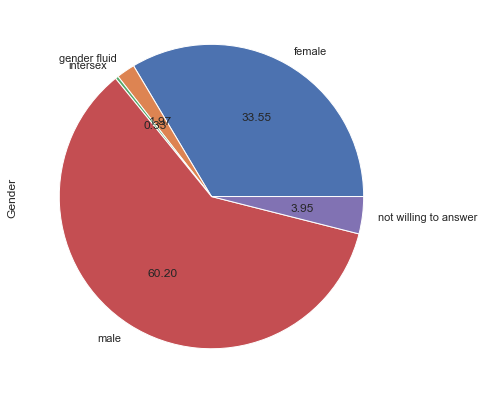

In [7]:
display(odi_df.groupby('Gender')['Gender'].count())
odi_df.groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
#mask = (odi_df['Gender']!='male') & (odi_df['Gender']!='female')
#odi_df['Gender'].loc[mask]

### Data treatment

In [8]:
odi_df[['Birthday' ]] = odi_df[['Birthday']].applymap(my_convert_to_date)
odi_df[['random_number', 'Stress', 'neighbors', 'Euros_Question' ]] = odi_df[['random_number', 'Stress', 'neighbors', 'Euros_Question']].applymap(my_convert_to_number)
odi_df[['ML','IR','DB','Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace({"yes", 'ja', "1"}, True)
odi_df[['ML','IR','DB', 'Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace({"no", 'nee', "0"}, False)
odi_df[['ML','IR','DB', 'Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace("unknown", None)


1998-05-02 00:00:00


### correlations

In [15]:
odi_df.corr(method ='pearson')

,neighbors,Stress,Euros_Question,random_number
neighbors,1.000000,-0.003453,-0.006193,-0.005803
Stress,-0.003453,1.000000,-0.006156,-0.000000
Euros_Question,-0.006193,-0.006156,1.000000,-0.006399
random_number,-0.005803,-0.000000,-0.006399,0.000000


### Pie chart of Gender put None as random number - no rule obeing 

Text(0.5, 1.0, 'gender distribution for correct data in random number')

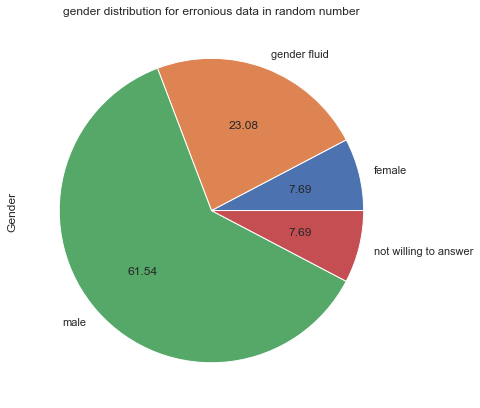

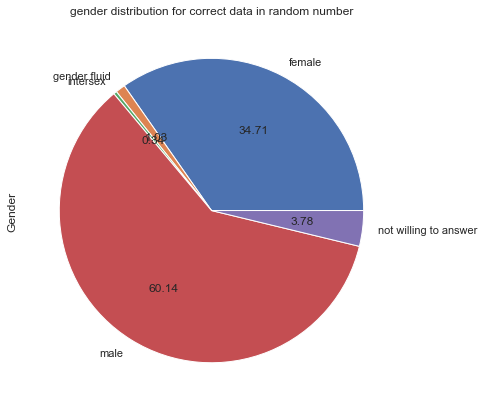

In [11]:
plt.figure(1)
odi_df[['Gender']].loc[odi_df['random_number'] .isna()].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for erronious data in random number')

plt.figure(2)
odi_df[['Gender']].loc[odi_df['random_number'] .isna()==False].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for correct data in random number')


### Good day distribution

In [12]:
dictionary=Counter(list(odi_df['good_day_1'].map(lambda x: x.lower()))+list(odi_df['good_day_2'].map(lambda x: x.lower())))
#sns.boxplot(pd.Series(dictionary, index=dictionary.keys()).sort_values(ascending=False), x=index)
#cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
#plt.figure(figsize=(16,12))
#plt.imshow(cloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()

#plt.bar(dictionary)
pd.set_option("display.max_rows", None, "display.max_columns", None)
odi_df['ML']

0       True
1       True
2       True
3       True
4       True
5      False
6       True
7       True
8       True
9      False
10     False
11      True
12      True
13     False
14      True
15      True
16     False
17     False
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26     False
27      True
28      True
29     False
30      True
31      True
32      True
33     False
34     False
35      True
36      True
37      True
38      True
39      True
40      True
41     False
42     False
43     False
44      True
45      True
46      True
47      True
48      True
49     False
50      True
51     False
52      True
53      True
54      True
55      True
56      True
57      True
58      True
59      True
60      True
61      True
62     False
63     False
64     False
65      True
66      True
67     False
68     False
69      True
70      True
71      True
72     False
73     False
74      True
75     False
76     False

In [13]:
frequent_itemsets = apriori(odi_df[['ML','IR','DB']], min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [14]:
print(rules)

   antecedents consequents  antecedent support  consequent support   support  \
0         (IR)        (ML)            0.269737            0.628289  0.223684   
1         (ML)        (IR)            0.628289            0.269737  0.223684   
2         (DB)        (ML)            0.539474            0.628289  0.384868   
3         (ML)        (DB)            0.628289            0.539474  0.384868   
4         (IR)        (DB)            0.269737            0.539474  0.223684   
5         (DB)        (IR)            0.539474            0.269737  0.223684   
6     (IR, DB)        (ML)            0.223684            0.628289  0.190789   
7     (DB, ML)        (IR)            0.384868            0.269737  0.190789   
8     (IR, ML)        (DB)            0.223684            0.539474  0.190789   
9         (DB)    (IR, ML)            0.539474            0.223684  0.190789   
10        (IR)    (DB, ML)            0.269737            0.384868  0.190789   
11        (ML)    (IR, DB)            0.